c:\Users\Win10\Documents\MEGA\mestrado\IM382ElementosFinitos2\im382\polynomials.py:61: RuntimeWarning: divide by zero encountered in divide
  DPn1 = (1 / b1n) * (b2n * Pn1 + b3n * Pn)
c:\Users\Win10\Documents\MEGA\mestrado\IM382ElementosFinitos2\im382\polynomials.py:61: RuntimeWarning: invalid value encountered in multiply
  DPn1 = (1 / b1n) * (b2n * Pn1 + b3n * Pn)
c:\Users\Win10\Documents\MEGA\mestrado\IM382ElementosFinitos2\im382\polynomials.py:61: RuntimeWarning: divide by zero encountered in divide
  DPn1 = (1 / b1n) * (b2n * Pn1 + b3n * Pn)
c:\Users\Win10\Documents\MEGA\mestrado\IM382ElementosFinitos2\im382\polynomials.py:61: RuntimeWarning: invalid value encountered in multiply
  DPn1 = (1 / b1n) * (b2n * Pn1 + b3n * Pn)
c:\Users\Win10\Documents\MEGA\mestrado\IM382ElementosFinitos2\im382\polynomials.py:61: RuntimeWarning: divide by zero encountered in divide
  DPn1 = (1 / b1n) * (b2n * Pn1 + b3n * Pn)
c:\Users\Win10\Documents\MEGA\mestrado\IM382ElementosFinitos2\im382\polynomial

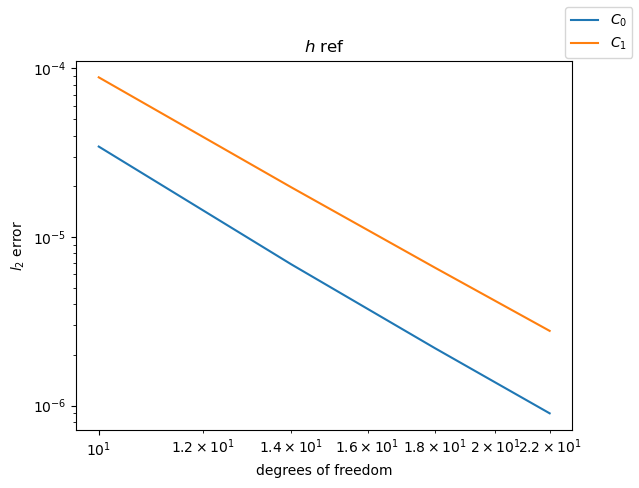

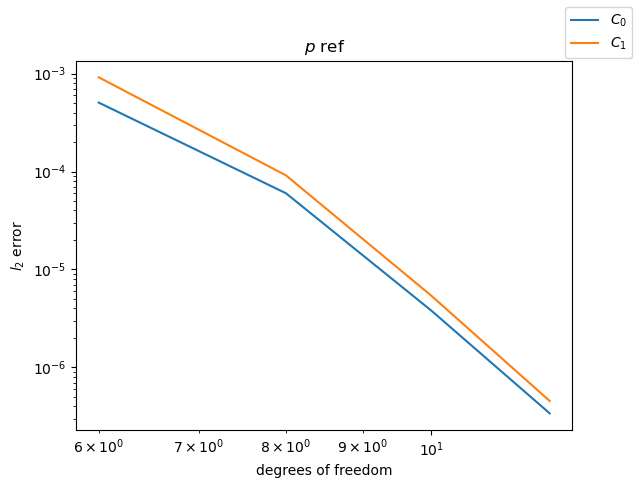

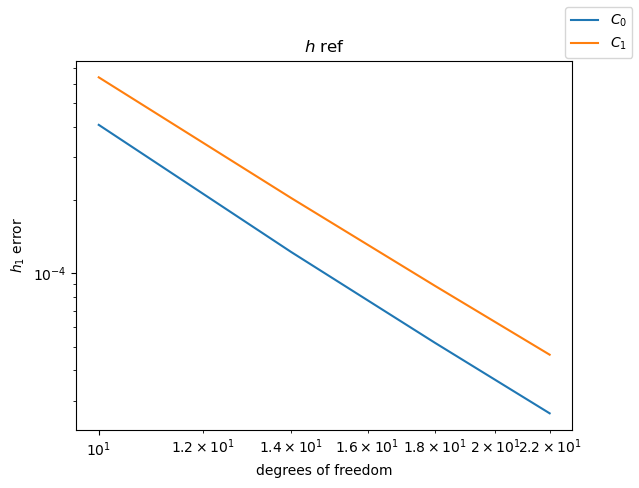

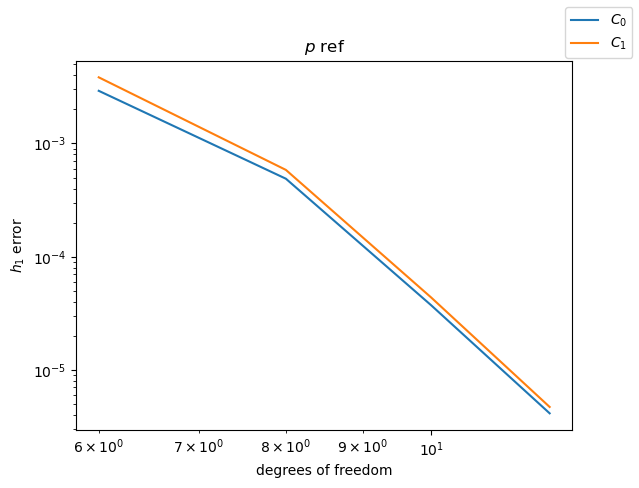

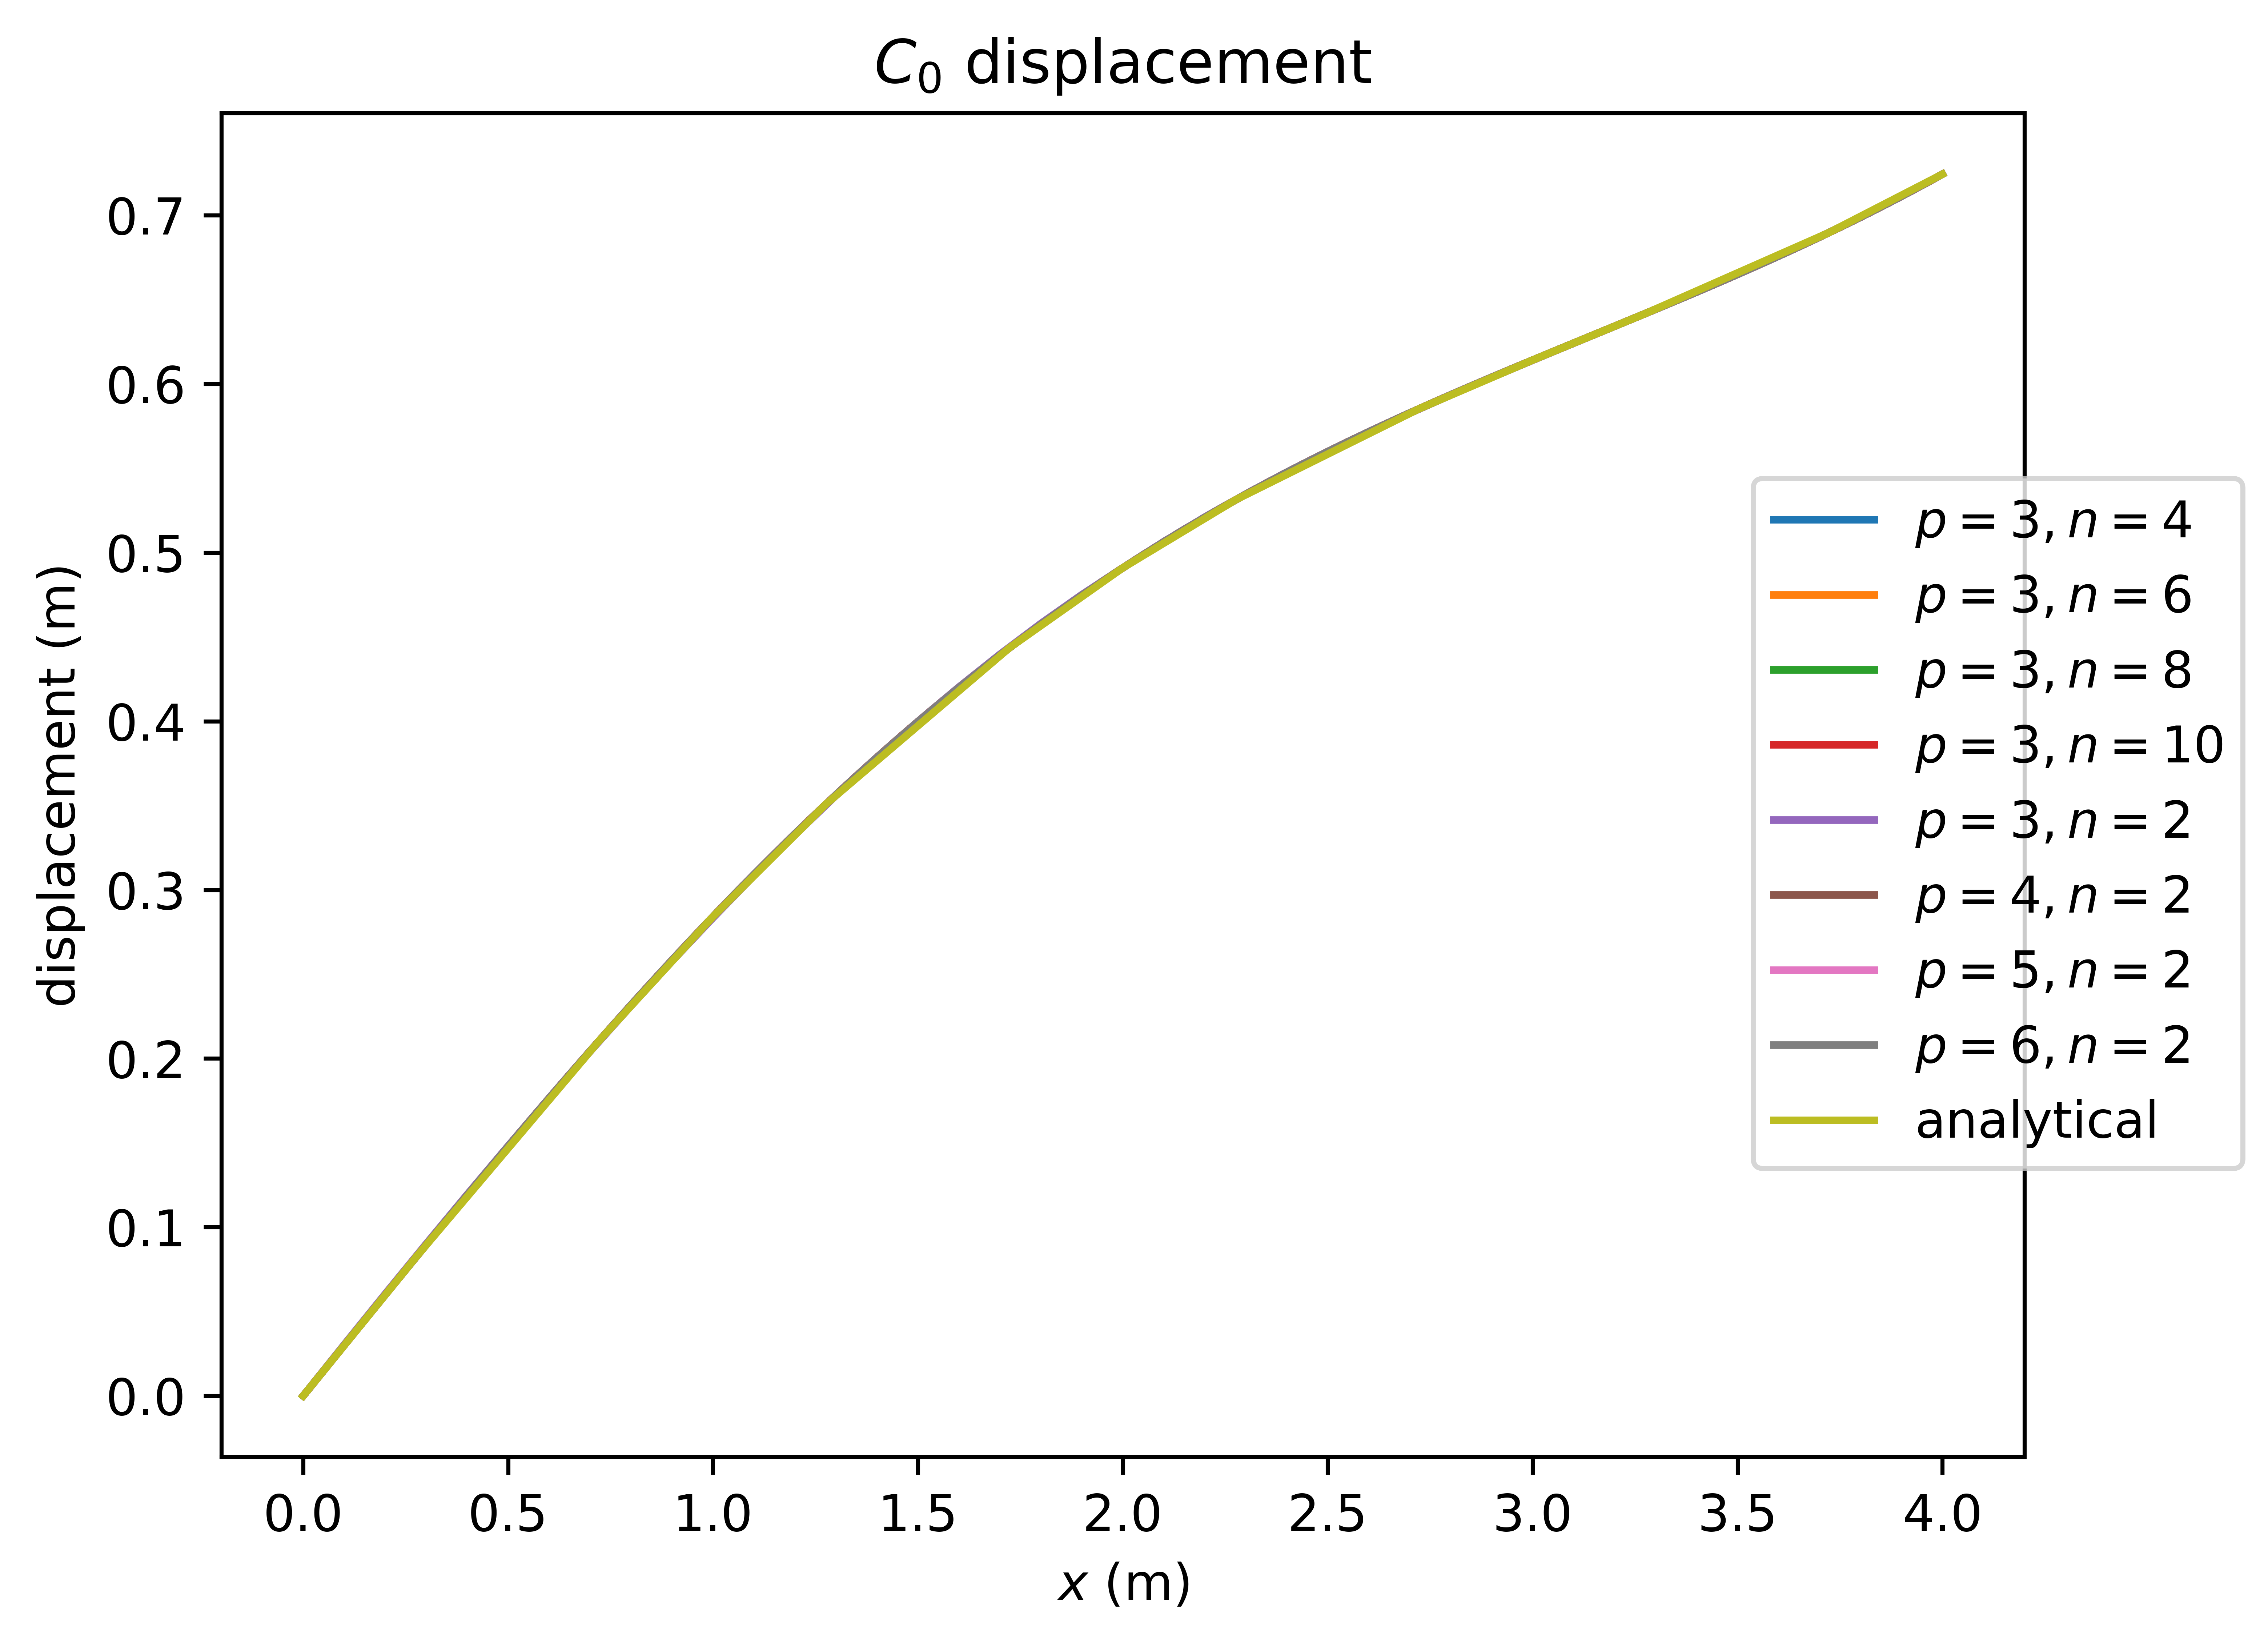

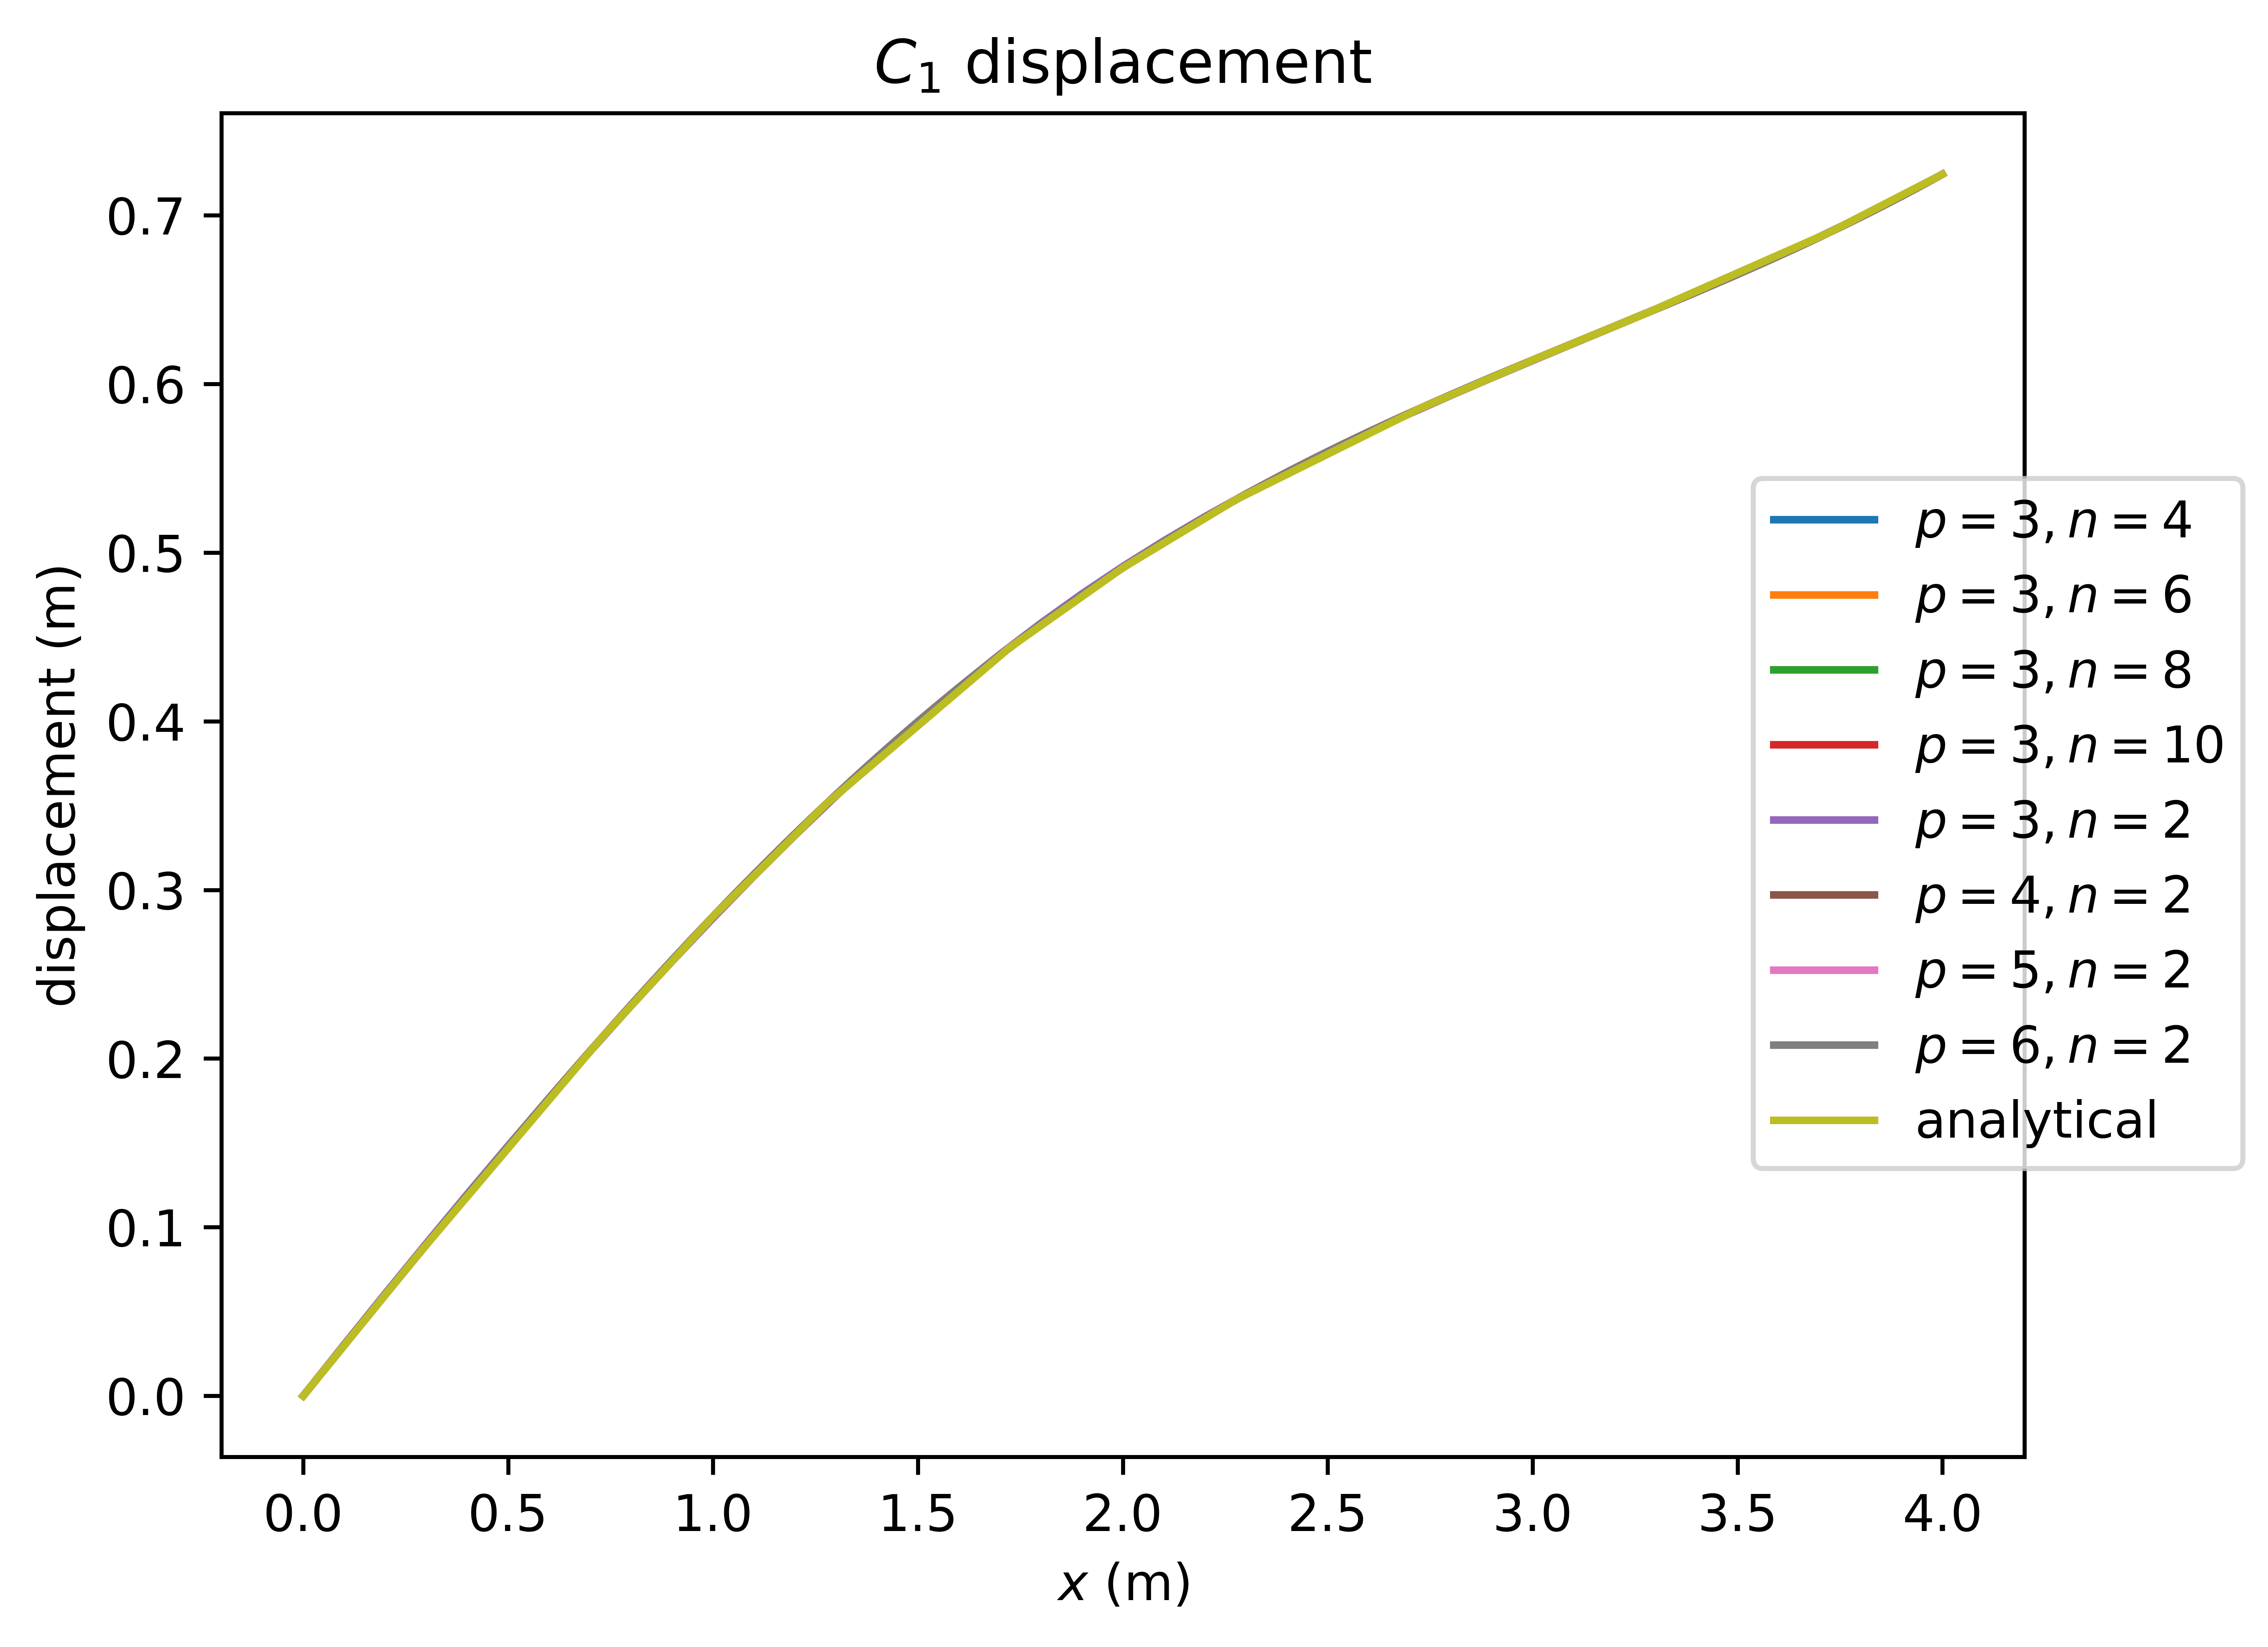

In [1]:
from dataclasses import replace
from functools import partial
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt

from bar_1d import BarInputNonLiner
from c0_basis import calc_ecsi_placement_coords_gauss_lobato
from lame import calc_lambda, calc_mu
from energy_norm import calc_energy_norm
from newton_raphson import (
    ConvergenceCriteria,
    NewtonRaphsonConvergenceParam,
    C0BarAnalysisInput,
    C1BarAnalysisInput,
    BarAnalysis,
)
from nomeclature import NUM_DISPLACEMENT, X_COORD


def pe(x: float):
    print(f"{x:e}")


young_modulus = 210e9
poisson = 0.3
lame_lambda = calc_lambda(young_modulus=young_modulus, poisson=poisson)
lame_mu = calc_mu(young_modulus=young_modulus, poisson=poisson)
section_area = 1.0e-3
length = 4.0
degree = 3
n_elements = 10
x = sy.symbols("x")
p, lambda_, mu, cp, A = sy.symbols("p lambda mu C_p A")
energy_norm = calc_energy_norm(
    mu=lame_mu, lambda_=lame_lambda, area=section_area, length=length
)
displacement_analytical_symb = 0.2 * p + 0.1 * sy.sin(p)  # type: ignore
displacement_analytical_num = sy.lambdify(p, displacement_analytical_symb)
derivative_displacement_analytical_symb = sy.diff(displacement_analytical_symb, p)
derivative_displacement_analytical_num = sy.lambdify(
    p, derivative_displacement_analytical_symb
)
grad_p = 1 + derivative_displacement_analytical_symb
cauchy_green = grad_p**2
stress_piolla_kirchhoff_2: sy.Expr = (
    mu * (1 - 1 / cp) + lambda_ * sy.ln(sy.sqrt(cp)) / cp
)
stress_piolla_kirchhoff_2 = stress_piolla_kirchhoff_2.subs(cp, cauchy_green)
stress_piolla_kirchhoff_2_num = sy.lambdify(
    p,
    stress_piolla_kirchhoff_2.subs(
        {A: section_area, lambda_: lame_lambda, mu: lame_mu, p: length}
    ),
)

stress_piolla_kirchhoff_1 = stress_piolla_kirchhoff_2 * grad_p
normal_1 = A * stress_piolla_kirchhoff_1
normal_1 = normal_1.simplify()
dist_load = -sy.diff(normal_1, p)
dist_load_num = sy.lambdify(
    p, dist_load.subs({lambda_: lame_lambda, mu: lame_mu, A: section_area})
)
load_at_end = normal_1.subs(
    {A: section_area, lambda_: lame_lambda, mu: lame_mu, p: length}
)


def stress_pk_2_manual(p: float):
    term = 0.1 * np.cos(p) + 1.2
    num = np.log(term)
    den = term**2
    return lame_lambda * num / den - lame_mu / (den - 1)


def stress_1_pk_manual(p: float):
    return stress_pk_2_manual(p) * (1.2 + 0.1 * np.cos(p))


def normal_force_manual(p: float):
    return stress_1_pk_manual(p) * section_area


bar_p_study = BarInputNonLiner(
    young_modulus=young_modulus,
    section_area=section_area,
    length=length,
    degree=1,
    n_elements=2,
    load_function=dist_load_num,
    poisson=poisson,
    load_at_end=load_at_end,
)

bar_h_study = BarInputNonLiner(
    young_modulus=young_modulus,
    section_area=section_area,
    length=length,
    degree=degree,
    n_elements=n_elements,
    load_function=dist_load_num,
    poisson=poisson,
    load_at_end=load_at_end,
)

convernge_criteria = NewtonRaphsonConvergenceParam(
    n_load_steps=10,
    max_iterations=100,
    convergence_criteria=ConvergenceCriteria.FORCE,
    precision=1e-7,
)

c0_bar_analysis_generator = partial(
    C0BarAnalysisInput,
    ecsi_placement_pts_function=calc_ecsi_placement_coords_gauss_lobato,
)

analysis_generator = partial(
    BarAnalysis,
    analytical_solution_function=displacement_analytical_num,
    analytical_derivative_solution_function=derivative_displacement_analytical_num,
    convergence_crit=convernge_criteria,
)

n_elements_cases = (4, 6, 8, 10)
degrees = (3, 4, 5, 6)


h_study_c0: dict[int, BarAnalysis] = dict()
p_study_c0: dict[int, BarAnalysis] = dict()
h_study_c1: dict[int, BarAnalysis] = dict()
p_study_c1: dict[int, BarAnalysis] = dict()

for n_elements in n_elements_cases:
    bar_input = replace(bar_h_study, n_elements=n_elements)
    c0_model = c0_bar_analysis_generator(bar_input=bar_input)
    c1_model = C1BarAnalysisInput(bar_input=bar_input)
    h_study_c0[n_elements] = analysis_generator(inputs=c0_model)
    h_study_c1[n_elements] = analysis_generator(inputs=c1_model)


for degree in degrees:
    bar_input = replace(bar_p_study, degree=degree)
    c0_model = c0_bar_analysis_generator(bar_input=bar_input)
    c1_model = C1BarAnalysisInput(bar_input=bar_input)
    p_study_c0[degree] = analysis_generator(inputs=c0_model)
    p_study_c1[degree] = analysis_generator(inputs=c1_model)


degrees_freedom_h = tuple(
    case.pre_process.n_degrees_freedom for case in h_study_c1.values()
)
l2_error_h_c0 = tuple(case.l2_error for case in h_study_c0.values())
l2_error_h_c1 = tuple(case.l2_error for case in h_study_c1.values())

h1_error_h_c0 = tuple(case.h1_error for case in h_study_c0.values())
h1_error_h_c1 = tuple(case.h1_error for case in h_study_c1.values())


degrees_freedom_p = tuple(
    case.pre_process.n_degrees_freedom for case in p_study_c1.values()
)
l2_error_p_c0 = tuple(case.l2_error for case in p_study_c0.values())
l2_error_p_c1 = tuple(case.l2_error for case in p_study_c1.values())


h1_error_p_c0 = tuple(case.h1_error for case in p_study_c0.values())
h1_error_p_c1 = tuple(case.h1_error for case in p_study_c1.values())

dfs = [
    (
        case.results(),
        case.inputs.bar_input.degree,
        case.inputs.bar_input.n_elements,
    )
    for case in h_study_c0.values()
]

dfs += [
    (
        case.results(),
        case.inputs.bar_input.degree,
        case.inputs.bar_input.n_elements,
    )
    for case in p_study_c0.values()
]


dfs_c1 = [
    (
        case.results(),
        case.inputs.bar_input.degree,
        case.inputs.bar_input.n_elements,
    )
    for case in h_study_c1.values()
]

dfs_c1 += [
    (
        case.results(),
        case.inputs.bar_input.degree,
        case.inputs.bar_input.n_elements,
    )
    for case in p_study_c1.values()
]


def plot_result(ax, result_df, key: str, name: str = "displacement"):
    ax.plot(result_df[X_COORD], result_df[key], label=name)


def plot_results(ax, result_dfs, key: str, name: str = "displacement"):
    for i, r in enumerate(result_dfs):
        plot_result(ax, r, key, f"{name} {i+2}")


ax3: plt.Axes
fig3, ax3 = plt.subplots()
ax3.set_title("$h$ ref")
ax3.set_xlabel("degrees of freedom")
ax3.set_ylabel("$l_2$ error")
ax3.loglog(degrees_freedom_h, l2_error_h_c0, label="$C_0$")
ax3.loglog(degrees_freedom_h, l2_error_h_c1, label="$C_1$")
fig3.legend()
fig3.savefig("ex31fig\l2 h ref")

ax4: plt.Axes
fig4, ax4 = plt.subplots()
ax4.set_title("$p$ ref")
ax4.set_xlabel("degrees of freedom")
ax4.set_ylabel("$l_2$ error")
ax4.loglog(degrees_freedom_p, l2_error_p_c0, label="$C_0$")
ax4.loglog(degrees_freedom_p, l2_error_p_c1, label="$C_1$")
fig4.legend()
fig4.savefig("ex31fig\l2 p ref")

ax5: plt.Axes
fig5, ax5 = plt.subplots()
ax5.set_title("$h$ ref")
ax5.set_xlabel("degrees of freedom")
ax5.set_ylabel("$h_1$ error")
ax5.loglog(degrees_freedom_h, h1_error_h_c0, label="$C_0$")
ax5.loglog(degrees_freedom_h, h1_error_h_c1, label="$C_1$")
fig5.legend()
fig5.savefig("ex31fig\h1 h ref")


ax6: plt.Axes
fig6, ax6 = plt.subplots()
ax6.set_title("$p$ ref")
ax6.set_xlabel("degrees of freedom")
ax6.set_ylabel("$h_1$ error")
ax6.loglog(degrees_freedom_p, h1_error_p_c0, label="$C_0$")
ax6.loglog(degrees_freedom_p, h1_error_p_c1, label="$C_1$")
fig6.legend()
fig6.savefig("ex31fig\h1 p ref")


study = h_study_c0[n_elements_cases[0]]
col_pts = study.pre_process.collocation_pts
col_pts_c1 = study.pre_process.collocation_pts
x_knots_c1 = study.pre_process.x_knots_global
col_pts_sorted = np.sort(col_pts)


ax_disp: plt.Axes
fig_disp, ax_disp = plt.subplots()
ax_disp.set_xlabel("$x$ (m)")
ax_disp.set_ylabel("displacement (m)")
ax_disp.set_title("$C_0$ displacement")
for df, degree, n in dfs:
    plot_result(
        ax=ax_disp, result_df=df, key=NUM_DISPLACEMENT, name=f"$p={degree}, n={n}$"
    )
ax_disp.plot(
    col_pts_sorted,
    [displacement_analytical_num(pt) for pt in col_pts_sorted],
    label="analytical",
)
fig_disp.legend(loc="right")
fig_disp.set_dpi(1000)
fig_disp.savefig("ex31fig\c0 disp")

ax_disp2: plt.Axes
fig_disp2, ax_disp2 = plt.subplots()
ax_disp2.set_xlabel("$x$ (m)")
ax_disp2.set_ylabel("displacement (m)")
ax_disp2.set_title("$C_1$ displacement")
for df, degree, n in dfs_c1:
    plot_result(
        ax=ax_disp2, result_df=df, key=NUM_DISPLACEMENT, name=f"$p={degree}, n={n}$"
    )

ax_disp2.plot(
    col_pts_sorted,
    [displacement_analytical_num(pt) for pt in col_pts_sorted],
    label="analytical",
)

fig_disp2.legend(loc="right")
fig_disp2.set_dpi(1000)
fig_disp2.savefig("ex31fig\c1 disp")